### Imports

In [23]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import time
import h5py
from pathlib import Path
import os
import matplotlib.pylab as pl

from art.attacks import FastGradientMethod
from art.classifiers.pytorch import PyTorchClassifier
from art.utils import load_cifar10

%matplotlib inline
%config InlineBackend.figure_format='retina'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Dataset

In [24]:
# Read CIFAR10 dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_cifar10()

x_train = np.swapaxes(x_train, 1, 3).astype(np.float32)
x_test = np.swapaxes(x_test, 1, 3).astype(np.float32)

train_dataset = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=128)

test_dataset = TensorDataset(torch.Tensor(x_test), torch.Tensor(y_test))
test_dataloader = DataLoader(test_dataset, batch_size=1000)
test_dataloader_single = DataLoader(test_dataset, batch_size=1)

### Inputs

In [47]:
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2]
path = Path("C:/Users/Matach/OneDrive - Imperial College London/ICL/FYP/Experiments/saved_models/CIFAR10/FGSM Adversarial/scenario_1")
file = "epsilon_10.pth"
pretrained_model = os.path.join(path, file)
use_cuda = True

## Model

In [48]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        self.conv_layer = nn.Sequential(

            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.dropout = nn.Dropout(p=0.1)
        self.fc1 = nn.Linear(4096, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# Initialize the model.
model = Model().to(device)

# Load pre-trained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
print(model.eval())

# Load loss and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

# Make a classifier wrapper!
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_, max_),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(3, 32, 32),
    nb_classes=10,
)

# Test model
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {} %".format(accuracy * 100))

CUDA Available:  True
Model(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Dropout2d(p=0.05, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dr

## FGSM

In [49]:
accuracies = []
k = 5000

# Run test for each epsilon
# for e in epsilons:
# for e in [0.25, 0.3]:
    adv_crafter = FastGradientMethod(classifier, eps=e)
    x_test_adv = adv_crafter.generate(x=x_test[:k])
    predictions = classifier.predict(x_test_adv)
    accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[:k], axis=1)) / k
    accuracies.append(accuracy)
    print("Epsilon: {}   Test Accuracy = {}".format(e, accuracy))
    
print(accuracies)

Epsilon: 0.25   Test Accuracy = 0.6012
Epsilon: 0.3   Test Accuracy = 0.5078
[0.6012, 0.5078]


# Results

### Scenario 1

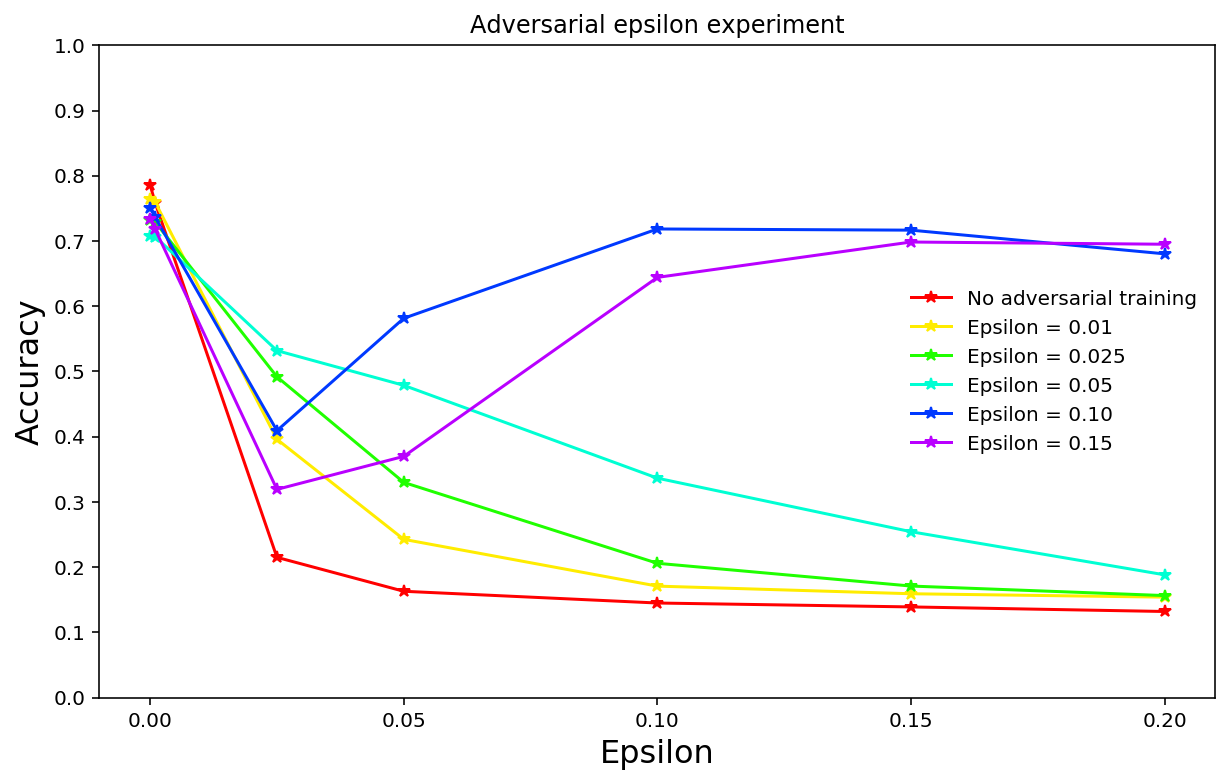

In [61]:
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2]
results = {
    'No adversarial training': [0.786, 0.7584, 0.215, 0.163, 0.145, 0.139, 0.132],
    'Epsilon = 0.01': [0.7642, 0.7594, 0.396 , 0.2426, 0.1709, 0.1592, 0.154 ],
    'Epsilon = 0.025': [0.7322, 0.729 , 0.4918, 0.3299, 0.2059, 0.171 , 0.1564],
    'Epsilon = 0.05': [0.7073, 0.7066, 0.5319, 0.4787, 0.3364, 0.2543, 0.1882],
    'Epsilon = 0.10': [0.7509, 0.7362, 0.4092, 0.5815, 0.7184, 0.7166, 0.6803],
    'Epsilon = 0.15': [0.7344, 0.7179, 0.3192, 0.3698, 0.6442, 0.6984, 0.695 ],
}

n = len(results)
colors = pl.cm.hsv(np.linspace(0,0.8,n))

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .25, step=0.05))
plt.title("Adversarial epsilon experiment")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### Scenario 2

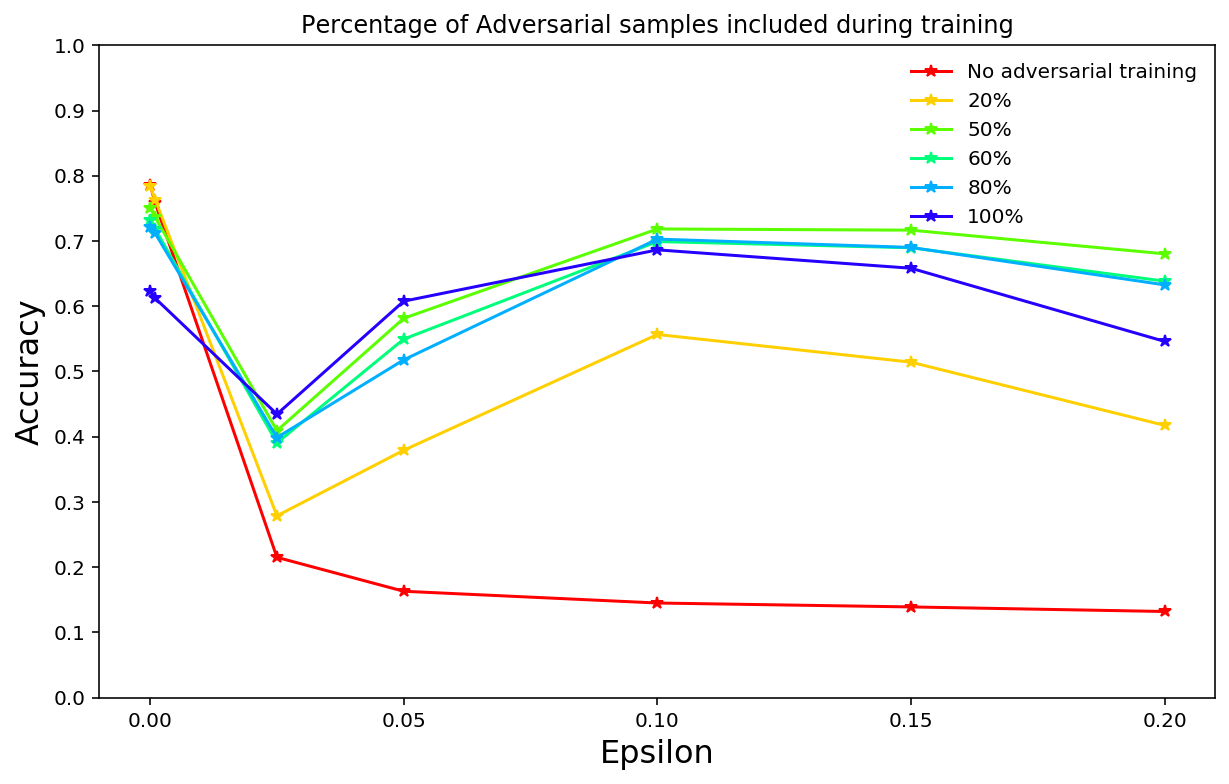

In [214]:
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2]
results = {
    'No adversarial training': [0.786, 0.7584, 0.215, 0.163, 0.145, 0.139, 0.132],
    '20%': [0.7837, 0.7634, 0.2787, 0.3792, 0.5567, 0.5142, 0.4173],
    '50%': [0.7509, 0.7362, 0.4092, 0.5815, 0.7184, 0.7166, 0.6803],
    '60%': [0.7319, 0.7183, 0.3905, 0.5496, 0.6991, 0.6896, 0.6384],
    '80%': [0.7217, 0.7117, 0.3987, 0.5178, 0.7029, 0.6901, 0.6327], 
    '100%': [0.6234, 0.6122, 0.4345, 0.6077, 0.6864, 0.6582, 0.546 ],
}

n = len(results)
colors = pl.cm.hsv(np.linspace(0,0.7,n))

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .25, step=0.05))
plt.title("Percentage of Adversarial samples included during training")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### Scenario 3

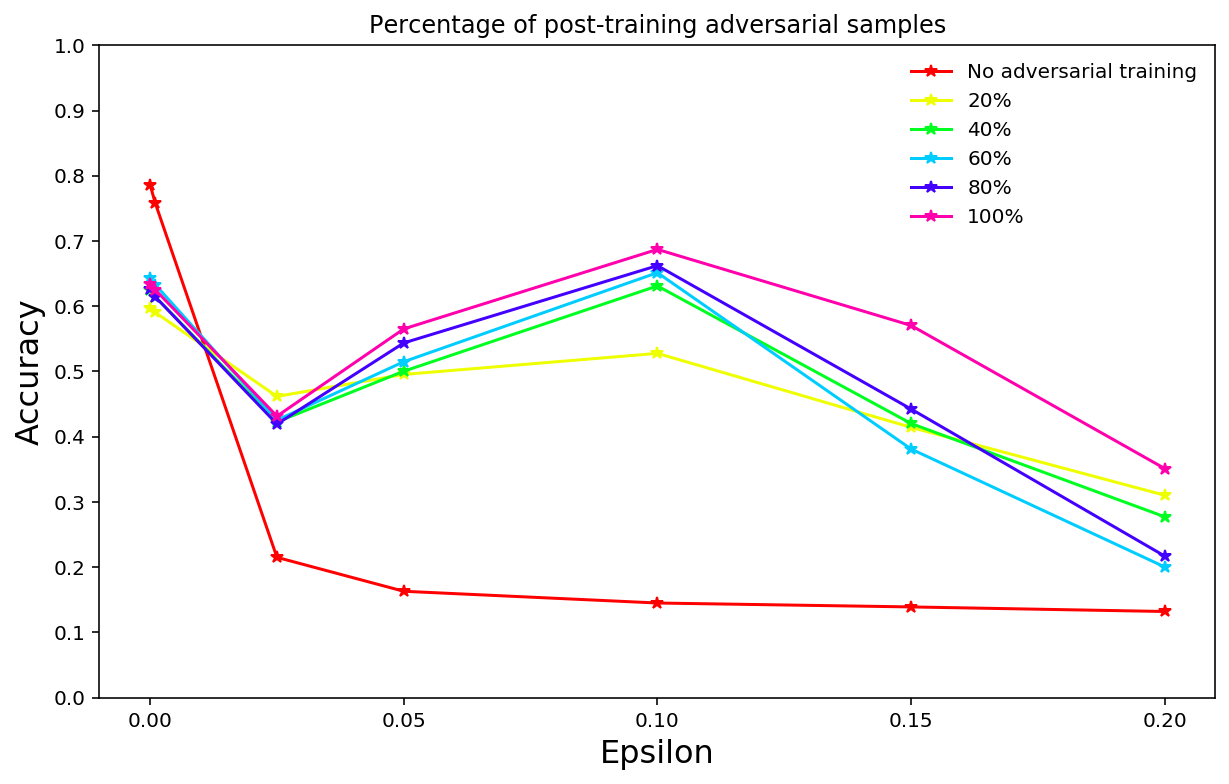

In [209]:
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2]
results = {
    'No adversarial training': [0.786, 0.7584, 0.215, 0.163, 0.145, 0.139, 0.132],
    '20%':[0.5976, 0.5905, 0.4617, 0.4954, 0.5277, 0.4143, 0.3102],
    '40%':[0.6244, 0.6147, 0.4226, 0.5003, 0.6311, 0.4202, 0.2772],
    '60%':[0.6439, 0.6332, 0.4253, 0.5149, 0.6514, 0.3811, 0.2003],
    '80%':[0.627 , 0.6146, 0.4193, 0.5437, 0.6622, 0.4424, 0.217 ], 
    '100%':[0.6337, 0.6253, 0.4314, 0.5652, 0.6871, 0.5705, 0.3512],
}

n = len(results)
colors = pl.cm.hsv(np.linspace(0,0.9,n))
# colors[0]=[0,0,0,0.8]

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .25, step=0.05))
plt.title("Percentage of post-training adversarial samples")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### Scenario 4

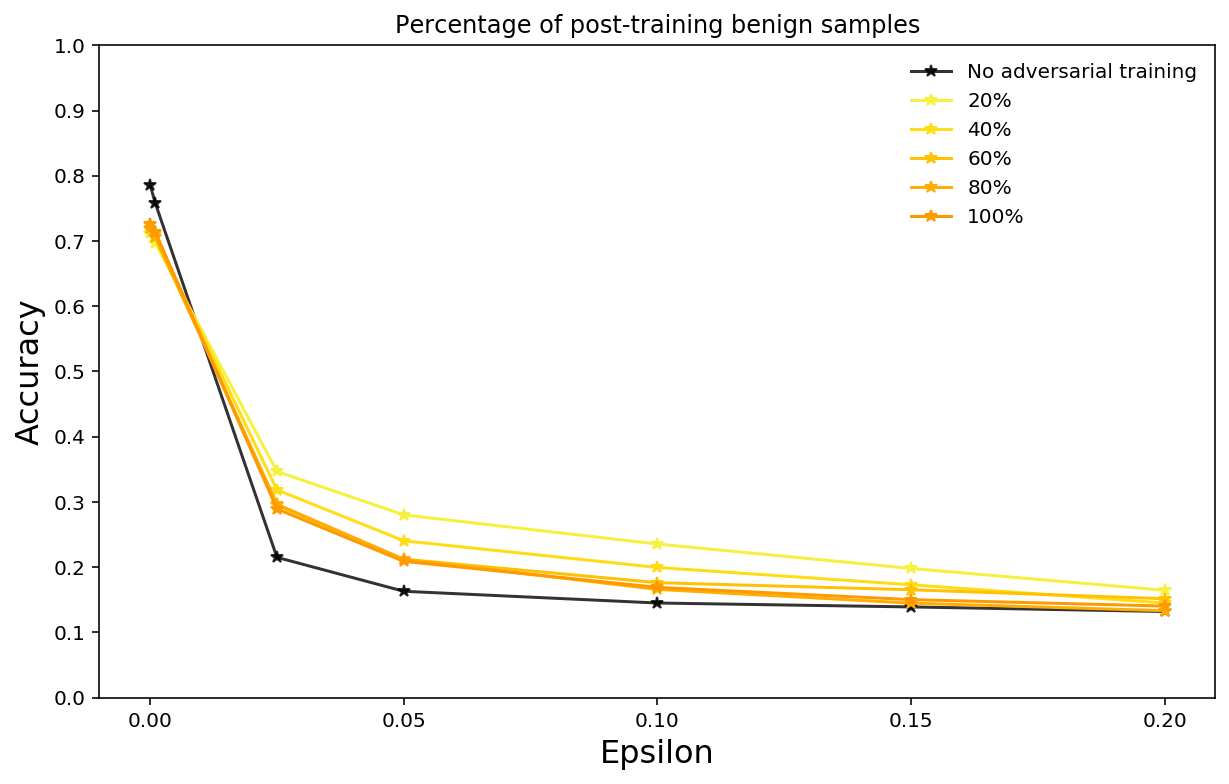

In [223]:
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2]
results = {
    'No adversarial training': [0.786, 0.7584, 0.215, 0.163, 0.145, 0.139, 0.132],
    '20%':[0.7119, 0.6969, 0.3467, 0.2801, 0.2354, 0.198 , 0.1645],
    '40%':[0.7189, 0.7066, 0.3185, 0.2404, 0.1995, 0.173 , 0.145 ],
    '60%':[0.7257, 0.7112, 0.2948, 0.2122, 0.1762, 0.1653, 0.1516],
    '80%':[0.7194, 0.7058, 0.2965, 0.212 , 0.1659, 0.1448, 0.1332], 
    '100%':[0.7261, 0.714 , 0.2892, 0.2089, 0.169 , 0.1502, 0.1403],
}

n = len(results)
colors = pl.cm.Wistia(np.linspace(0,0.8,n))
colors[0]=[0,0,0,0.8]

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .25, step=0.05))
plt.title("Percentage of post-training benign samples")
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()

### Scenario mix

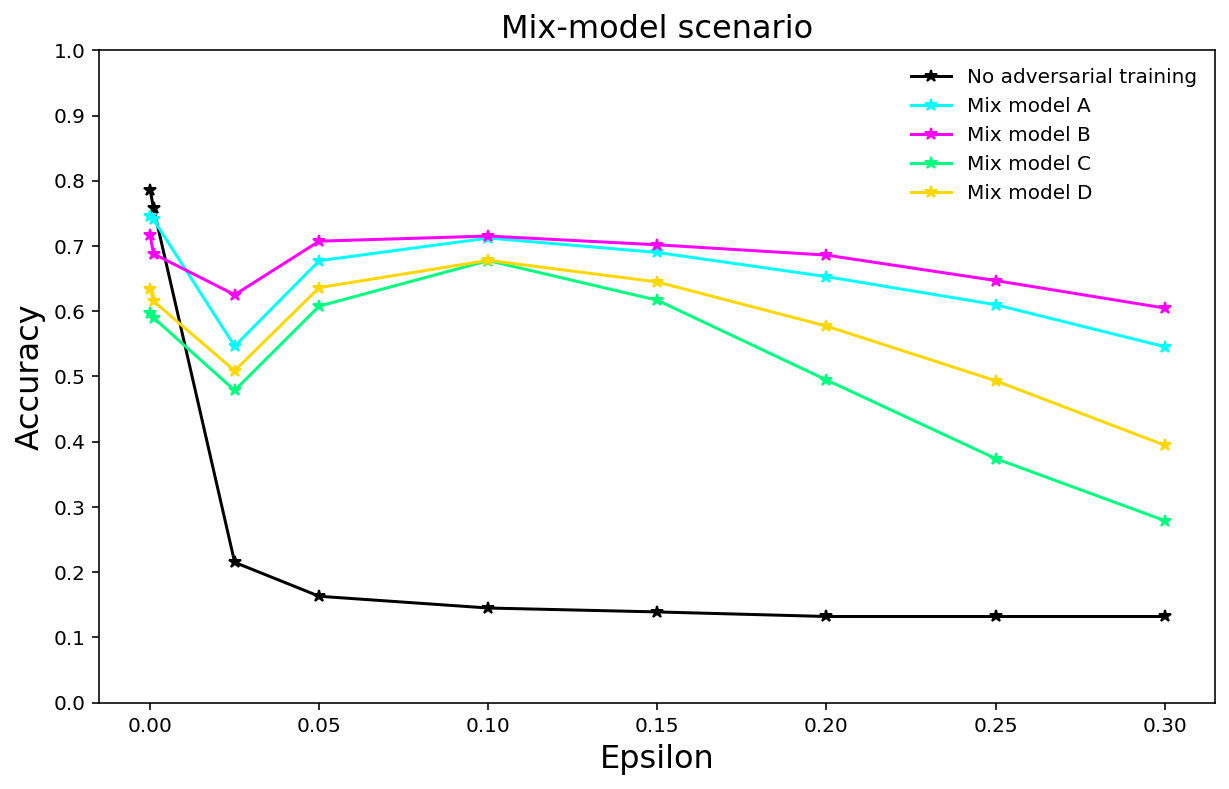

In [42]:
epsilons = [0.000001, 0.001, .025, .05, .1, .15, .2, .25, .3]
results = {
    'No adversarial training': [0.786, 0.7584, 0.215, 0.163, 0.145, 0.139, 0.132, 0.132, 0.132],
    'Mix model A': [0.7458, 0.7406, 0.5464, 0.6774, 0.7122, 0.69, 0.653, 0.61, 0.5456],
    'Mix model B': [0.7162, 0.688, 0.6252, 0.7074, 0.7152, 0.7018, 0.686, 0.647, 0.6048],
    'Mix model C': [0.597, 0.59, 0.4786, 0.6078, 0.6776, 0.6168, 0.4946, 0.3742, 0.279],
    'Mix model D': [0.634, 0.6154, 0.5088, 0.6362, 0.678, 0.6448, 0.5772,0.4934, 0.3946 ]   
}

n = len(results)
colors = pl.cm.Wistia(np.linspace(0,0.8,n))
colors[0]=[0,0,0,0.8]

colors = ['black', 'cyan', 'fuchsia', 'springgreen', 'gold', 'aquamarine']

plt.figure(figsize=(10,6))

for idx, (pg, results) in enumerate(results.items()):
    plt.plot(epsilons, results, "*-", color=colors[idx], label=pg)

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Mix-model scenario", fontsize=16)
plt.xlabel("Epsilon",fontsize=16)
plt.ylabel("Accuracy",fontsize=16)
plt.legend(loc='best', frameon=False)
plt.show()